In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt  # root-finding algorithm
import importlib  # Built-in module
from src import plotting
from src import utils
from src import tuning
from src import fp
from src import eig
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%config InlineBackend.figure_format = 'retina'


/Users/ver/postdoc_projects/balancing/src/tuning.py:124: RuntimeWarning: invalid value encountered in log
  x = np.where(y >= 0, (y + b) / a, (np.log(y / d + 1) + b) / a)


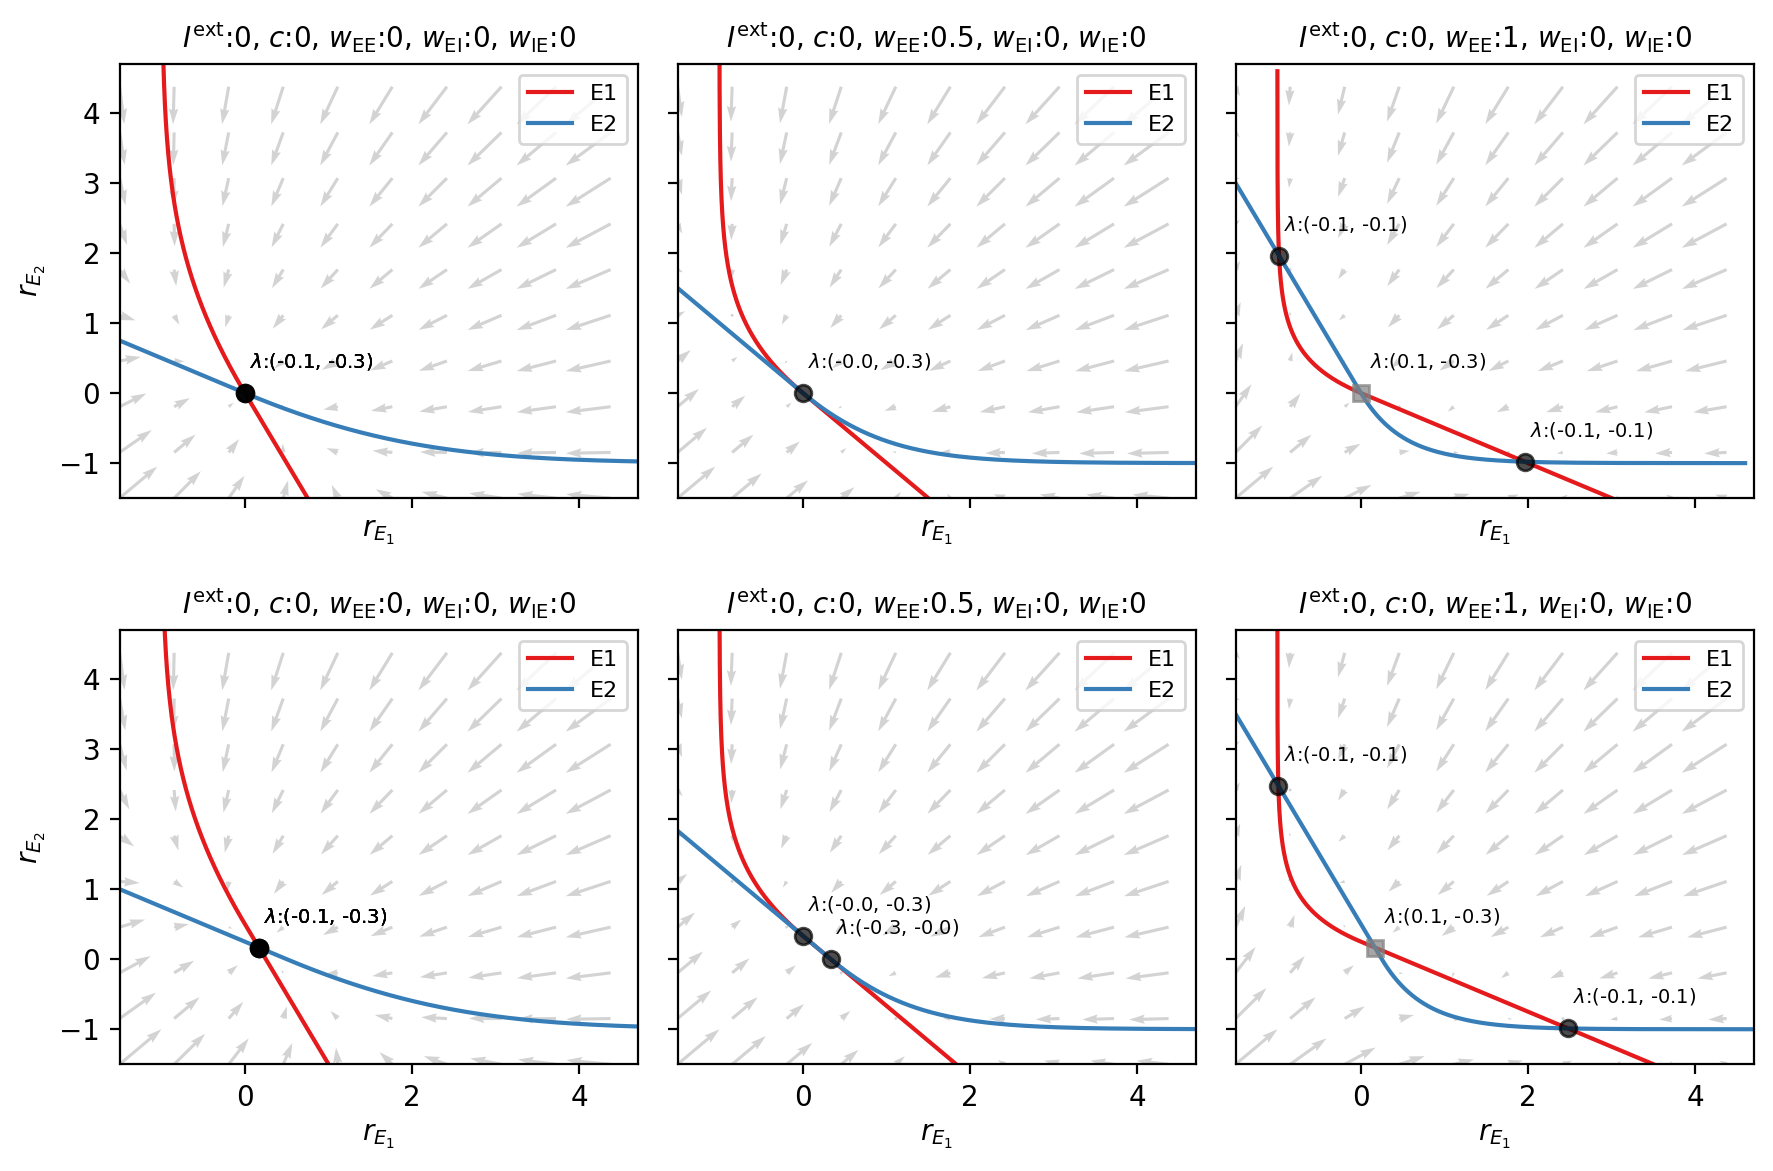

In [2]:
plotting = importlib.reload(plotting)
utils = importlib.reload(utils)
fp = importlib.reload(fp)
eig = importlib.reload(eig)
tuning = importlib.reload(tuning)
from src.plotting import colors

def update_plot(wEEs, stimuli_strength, noise, ordi, rE_limits, coherence):
    pars = utils.thesis_pars()
    pars["wEI"] = wEI = 0
    pars["wIE"] = wIE = 0
    pars["coherence_range"] = (coherence, coherence)
    
    T = 50000
    plot_size2 = len(stimuli_strength)
    plot_size = len(wEEs)
    if ordi == 1:
        plot_size, plot_size2 = plot_size2, plot_size
    fig, axes = plt.subplots(plot_size2, plot_size, figsize=(3* plot_size, 3 * plot_size2),
                           sharex='col', sharey='row',
                           squeeze=False,
                             )
    # coherence = 0.
    for ii, (stimulus_strength, noise_val) in enumerate(zip(stimuli_strength, noise)):
        for jj, wEE in enumerate(wEEs):
            pars['wEE'] = wEE
            if ordi == 1:
                ax = axes[jj, ii]
            else:
                ax = axes[ii, jj]
            pars["stimulus_strength"] = stimulus_strength
       
            I_ext_E1 = np.full((1, T), stimulus_strength * (1 - coherence))
            I_ext_E2 = np.full((1, T), stimulus_strength * (1 + coherence))
            I_ext_E = np.concatenate([I_ext_E1, I_ext_E2], axis=0)
            I_ext_I = np.zeros((2, T))
            noise_mean = np.full((2, T), noise_val)
            
            # null_rE0, null_rE1  = np.linspace(rE_limits[0], rE_limits[1], T), np.linspace(rE_limits[0], rE_limits[1], T)
            # 

            Exc_null_rE0, Exc_null_rE1  = np.linspace(rE_limits[0], rE_limits[1], T), np.linspace(rE_limits[0], rE_limits[1], T)
            null_rE0, null_rE1 = np.zeros((1, T)), np.zeros((1, T))
            null_rI = np.zeros((2, T))
            null_rE0[0, :] = Exc_null_rE0
            null_rE1[0, :] = Exc_null_rE1
            null_rE = np.concatenate([null_rE0, null_rE1], axis=0)
            
            pars['I_ext_E'] = I_ext_E
            pars['I_ext_I'] = I_ext_I
            pars['noise_mean'] = noise_mean
            
            null_rE1_from_rE0 = utils.get_Eop_from_E_nullcline(0, null_rE, **pars)
            null_rE0_from_rE1 = utils.get_Eop_from_E_nullcline(1, null_rE, **pars)
          
            ax.plot(Exc_null_rE0, null_rE1_from_rE0, colors[0], label='E1')
            ax.plot(null_rE0_from_rE1, Exc_null_rE1, colors[1], label='E2')

            my_n_skip=2
            myscale=10

            I_ext_E1 = np.full((1, 400), stimulus_strength * (1 - coherence))
            I_ext_E2 = np.full((1, 400), stimulus_strength * (1 + coherence))
            I_ext_E = np.concatenate([I_ext_E1, I_ext_E2], axis=0)
            noise_mean = np.full((2, 400), noise_val)
            pars['I_ext_E'] = I_ext_E
            pars['I_ext_I'] = np.zeros((2, 400))
            pars['noise_mean'] = noise_mean
            # pars['rI_init'] = np.zeros((2, 400))

            EE_grid = np.linspace(rE_limits[0], rE_limits[1], 20)
            rE1, rE2 = np.meshgrid(EE_grid, EE_grid)
            rE = np.stack([rE1.reshape(-1), rE2.reshape(-1)], axis=0)
            drEdt = utils.batch_EIderivs_E2(rE, **pars).reshape(2, 20, 20)
            rE = rE.reshape(2, 20, 20)
            n_skip = my_n_skip
            ax.quiver(rE[0, ::n_skip, ::n_skip], rE[1, ::n_skip, ::n_skip],
                      drEdt[0, ::n_skip, ::n_skip], drEdt[1, ::n_skip, ::n_skip],
                      angles='xy', scale_units='xy', scale=myscale, facecolor='lightgray')
            ax.set_ylim(rE_limits[0], rE_limits[1])
            ax.set_xlim(rE_limits[0], rE_limits[1])
            ax.set_xlabel(r'$r_{E_1}$', fontsize=10)
            ie = r"$I^{\text{ext}}$"
            wee = r"$w_{\mathrm{EE}}$"
            wei = r"$w_{\mathrm{EI}}$"
            wie = r"$w_{\mathrm{IE}}$"
            c = r"$c$"
            ax.set_title(f"{ie}:{stimulus_strength}, {c}:{coherence}, {wee}:{wEE}, {wei}:{wEI}, {wie}:{wIE}", fontsize=10)

            x_fps = []
            for rEini in [[rE_limits[0], rE_limits[1]], [rE_limits[1], rE_limits[0]], [rE_limits[0], rE_limits[0]], [rE_limits[1], rE_limits[1]]]:
                pars2 = utils.thesis_pars(rE_init=rEini, I_ext_E=I_ext_E[:,1], wEE=wEE, noise_mean=noise_mean[:, 1])
                pars2["stimulus_strength"] = stimulus_strength
                # Find the fixed point
                x_fp1 = fp.my_fp_E2(**pars2)
                marker='o'
                color = 'k'

                eig_1, J, stability_cond = eig.get_eig_Jacobian_E2(x_fp1,  **pars2)
  
                if np.any(np.iscomplex(eig_1)) or np.any(eig_1 > 0):
                    marker = 's'
                    color = 'gray'
                    
                exists = False
                for x_f in x_fps:
                    if abs(x_fp1[0] - x_f[0]) < 3e-1 and abs(x_fp1[1] == x_f[1]) < 3e-1:
                        exists = True
                        break
                if exists:
                    continue
                if fp.check_fp_E2(pars2, x_fp=x_fp1):
                    plotting.plot_fp(x_fp1, ax=ax, eig=eig_1, marker=marker, color=color)
                    x_fps.append(x_fp1)
                ax.legend(loc='best', fontsize=8)
        if ordi == 1:
            axes[jj,0].set_ylabel(r'$r_{E_2}$', fontsize=10)
        else:
            axes[ii,0].set_ylabel(r'$r_{E_2}$', fontsize=10)
    plt.tight_layout()
    plt.show()

# update_plot(wEEs=[0., 0.5, 1.], stimuli_strength=[0., 1], ordi=0, rE_limits = (-1.5,4.7), coherence=0)

update_plot(wEEs=[0, 0.5, 1], stimuli_strength=[0, 0], ordi=0, rE_limits = (-1.5,4.7), coherence=0, noise=[0., 0.5])

# update_plot(wEEs=[0, 2, 3], stimuli_strength=[0], ordi=0, rE_limits = (-2.5,2.5))


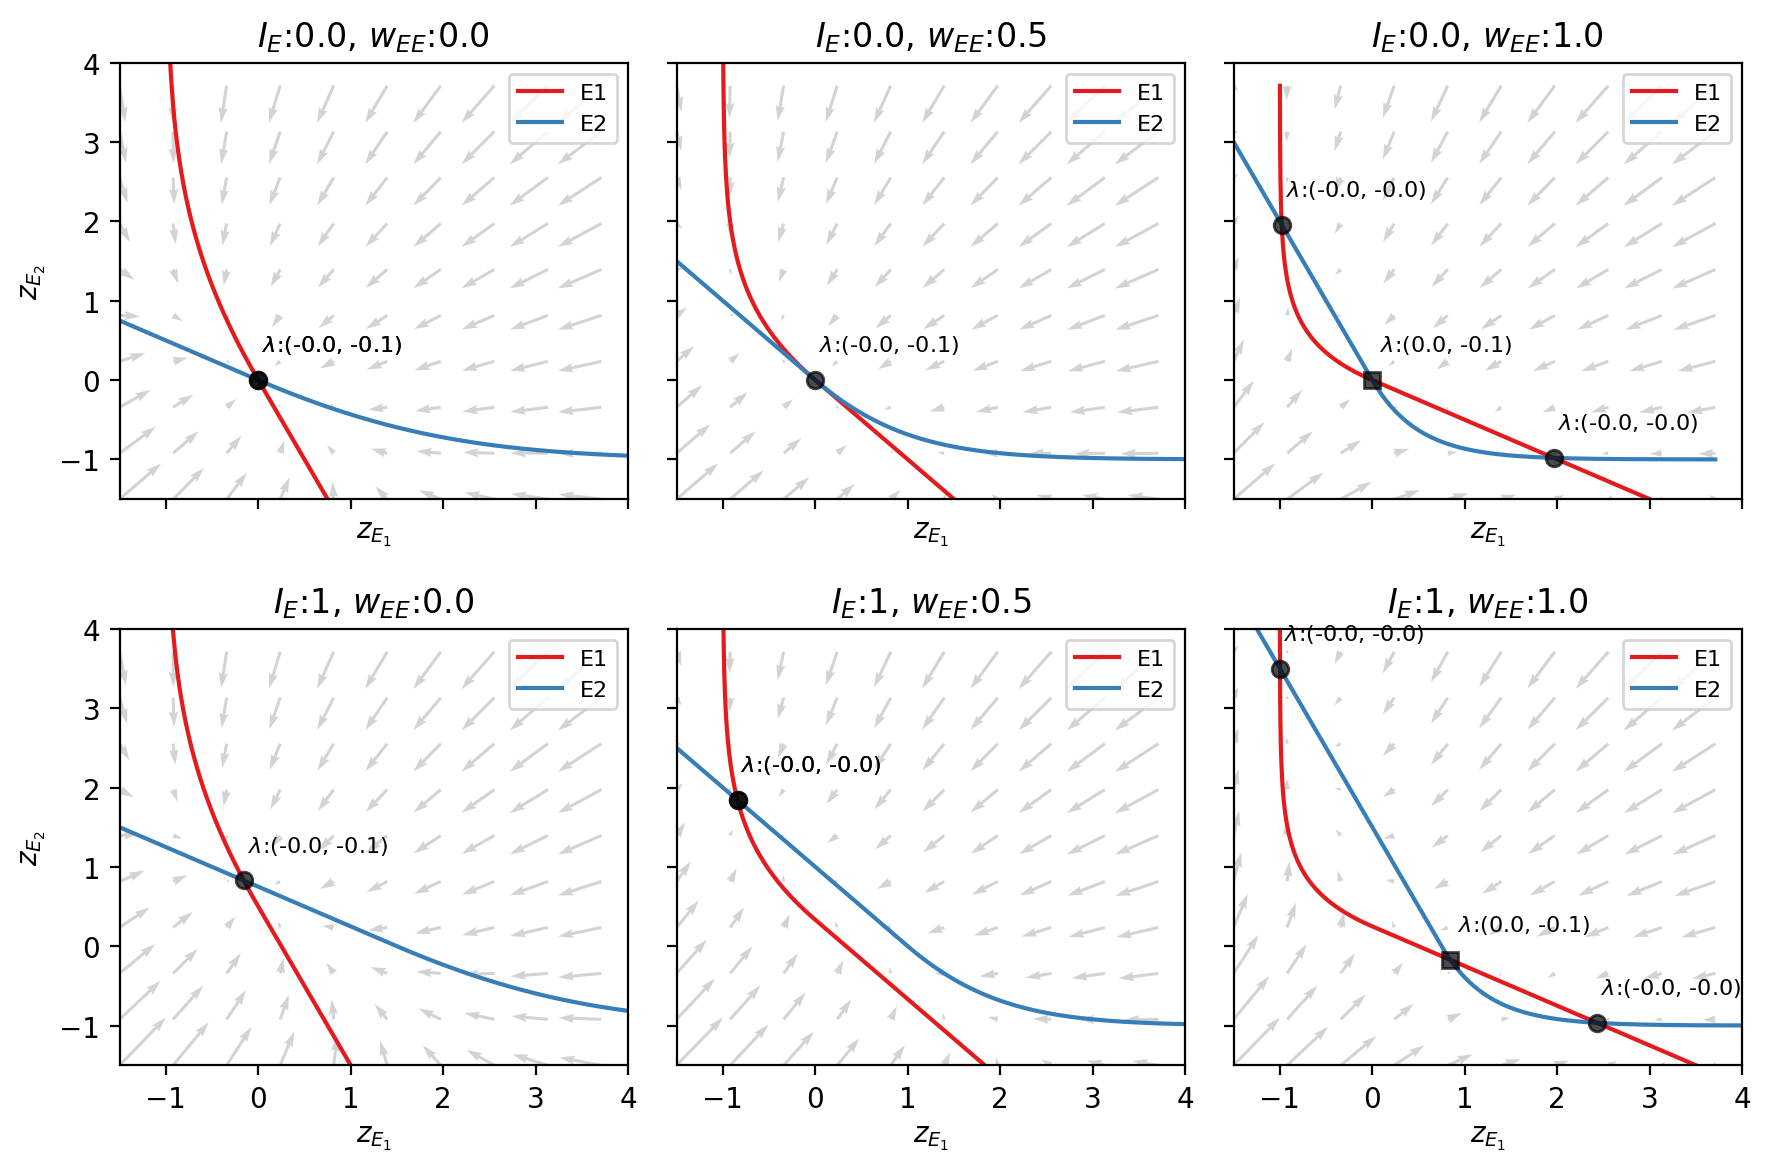

In [8]:
plotting = importlib.reload(plotting)
utils = importlib.reload(utils)
fp = importlib.reload(fp)
eig = importlib.reload(eig)
tuning = importlib.reload(tuning)
from src.plotting import colors

def update_plot(wEEs, stimuli_strength, ordi, rE_limits, coherence):
    pars = utils.thesis_pars()
    T = 5000
    plot_size2 = len(stimuli_strength)
    plot_size = len(wEEs)
    if ordi == 1:
        plot_size, plot_size2 = plot_size2, plot_size
    fig, axes = plt.subplots(plot_size2, plot_size, figsize=(3* plot_size, 3 * plot_size2),
                             sharex='col', sharey='row',
                             squeeze=False,
                             )
    # coherence = 0.
    for ii, stimulus_strength in enumerate(stimuli_strength):
        for jj, wEE in enumerate(wEEs):
            pars['wEE'] = wEE
            if ordi == 1:
                ax = axes[jj, ii]
            else:
                ax = axes[ii, jj]
            pars["stimulus_strength"] = stimulus_strength

            I_ext_E1 = np.full((1, T), stimulus_strength * (1 - coherence))
            I_ext_E2 = np.full((1, T), stimulus_strength * (1 + coherence))
            I_ext_E = np.concatenate([I_ext_E1, I_ext_E2], axis=0)
            I_ext_I = np.zeros((2, T))

            # null_rE0, null_rE1  = np.linspace(rE_limits[0], rE_limits[1], T), np.linspace(rE_limits[0], rE_limits[1], T)
            # 

            Exc_null_rE0, Exc_null_rE1  = np.linspace(rE_limits[0], rE_limits[1], T), np.linspace(rE_limits[0], rE_limits[1], T)
            null_rE0, null_rE1 = np.zeros((1, T)), np.zeros((1, T))
            null_rI = np.zeros((2, T))
            null_rE0[0, :] = Exc_null_rE0
            null_rE1[0, :] = Exc_null_rE1
            null_rE = np.concatenate([null_rE0, null_rE1], axis=0)

            pars['I_ext_E'] = I_ext_E
            pars['I_ext_I'] = I_ext_I

            null_rE1_from_rE0 = utils.get_Eop_from_E_nullcline(0, null_rE, **pars)
            null_rE0_from_rE1 = utils.get_Eop_from_E_nullcline(1, null_rE, **pars)

            ax.plot(Exc_null_rE0, null_rE1_from_rE0, colors[0], label='E1')
            ax.plot(null_rE0_from_rE1, Exc_null_rE1, colors[1], label='E2')

            my_n_skip=2
            myscale=10

            I_ext_E1 = np.full((1, 400), stimulus_strength * (1 - coherence))
            I_ext_E2 = np.full((1, 400), stimulus_strength * (1 + coherence))
            I_ext_E = np.concatenate([I_ext_E1, I_ext_E2], axis=0)
            pars['I_ext_E'] = I_ext_E
            pars['I_ext_I'] = np.zeros((2, 400))
            pars['noise'] = np.zeros((2, 400))
            # pars['rI_init'] = np.zeros((2, 400))

            EE_grid = np.linspace(rE_limits[0], rE_limits[1], 20)
            rE1, rE2 = np.meshgrid(EE_grid, EE_grid)
            rE = np.stack([rE1.reshape(-1), rE2.reshape(-1)], axis=0)
            drEdt = utils.batch_EIderivs_E2(rE, **pars).reshape(2, 20, 20)
            rE = rE.reshape(2, 20, 20)
            n_skip = my_n_skip
            ax.quiver(rE[0, ::n_skip, ::n_skip], rE[1, ::n_skip, ::n_skip],
                      drEdt[0, ::n_skip, ::n_skip], drEdt[1, ::n_skip, ::n_skip],
                      angles='xy', scale_units='xy', scale=myscale, facecolor='lightgray')
            ax.set_ylim(rE_limits[0], rE_limits[1])
            ax.set_xlim(rE_limits[0], rE_limits[1])
            ax.set_xlabel(r'$z_{E_1}$', fontsize=10)
            ie = r"$I_E$"
            wee = r"$w_{EE}$"
            ax.set_title(f"{ie}:{stimulus_strength}, {wee}:{wEE}")

            x_fps = []
            for rEini in [[rE_limits[0], rE_limits[1]], [rE_limits[1], rE_limits[0]], [rE_limits[0], rE_limits[0]], [rE_limits[1], rE_limits[1]]]:
                pars2 = utils.thesis_pars(rE_init=rEini, I_ext_E=I_ext_E[:,1], wEE=wEE)
                pars2["stimulus_strength"] = stimulus_strength
                # Find the fixed point
                x_fp1 = fp.my_fp_E2(**pars2)
                marker='o'

                eig_1 = eig.get_eig_Jacobian_E2(x_fp1,  **pars2)

                if np.any(np.iscomplex(eig_1)) or np.any(eig_1 > 0):
                    marker = 's'

                exists = False
                for x_f in x_fps:
                    if abs(x_fp1[0] - x_f[0]) < 3e-1 and abs(x_fp1[1] == x_f[1]) < 3e-1:
                        exists = True
                        break
                if exists:
                    continue
                if fp.check_fp_E2(pars2, x_fp=x_fp1):
                    plotting.plot_fp(x_fp1, ax=ax, eig=eig_1, marker=marker)
                    x_fps.append(x_fp1)
                ax.legend(loc='best', fontsize=8)
        if ordi == 1:
            axes[jj,0].set_ylabel(r'$z_{E_2}$', fontsize=10)
        else:
            axes[ii,0].set_ylabel(r'$z_{E_2}$', fontsize=10)
    plt.tight_layout()
    plt.show()
    
update_plot2(wEEs=[0., 0.5, 1.], stimuli_strength=1, ordi=0, rE_limits = (-1.6,4.6), coherences=[0,0.5,1])